# RNN

## 1. RNN 의 특징

테이터로부터 과거 패턴을 학습한 RNN 은 과거 패턴이 미래에도 여전히 유효하다고 가정하고 그 지식을 사용해 미래를 예측할 수 있습니다.

일반적으로 RNN 은 고정길이가 아닌 임의 길이의 시퀀스를 다룰 수 있습니다.
(시퀀스 : 순차적으로 배열된 데이터의 집합)

### 2. 순환 뉴련과 순환 층
수식은 어려우니 우선 그림으로 단순화해서 살펴보죠.

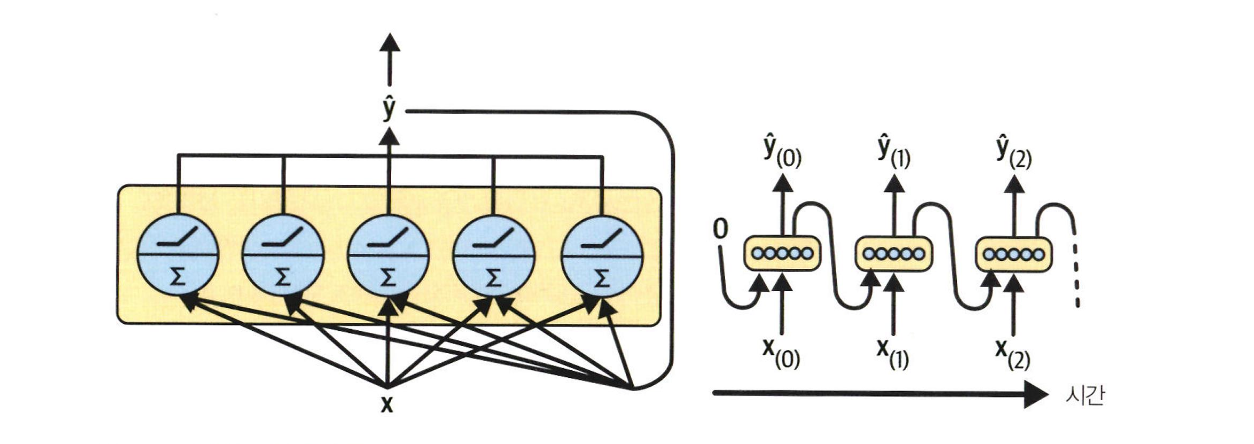

In [14]:
from IPython.display import Image
Image("./이미지파일/단일퍼셉트론.png",width=800,height=800) #1. 단일 뉴런일때
Image("./이미지파일/다중퍼셉트론.png",width=800,height=800) #2. 다중 뉴런일때

(이미지 파일 크기를 위해 코드로 실행한 점 양해부탁드립니다.)

$\hat{Y}_{(t)} = \phi(X_{(t)} W_{X}+ \hat{Y}_{(t-1)} W_{Y}+b)$

$= \phi ([X_{(t)} \hat{Y}_{(t-1)}] W+b)$, where $W=\begin{pmatrix} W_{X}\\W_{Y} \end{pmatrix}$

수식은 중요하지 않으니 참고하시면 됩니다.

### 2.1 메모리셀

타임 스텝 $t$에서 순환뉴련(위의그림)은 이전 타임스텝들의 모든 입력에 대한 함수이므로 일종의 `메모리`셀이라고 할 수 있습니다.

일반적으로 (문제에 따라 다르겠지만) 하나의 순환뉴런 혹은 순환뉴련의 층은 10스텝 정도의 길이만 학습할 수 있는 기본적인 셀입니다.

### 2.2 입력 시퀀스와 출력 시퀀스

위와 같은 구조는 입력 시퀀스를 받아 다양한 출력 형태를 만들 수 있는데 아래와 같습니다.

- 시퀀스 투 시퀀스 : 입력 시퀀스로 출력 시퀀스를 만듭니다. 시계열데이터를 예측하는데 유용합니다.

- 시퀀스 두 벡터 :  출력 시퀀스가 아닌 마지막 출력만 사용할 수 있습니다. 예를 들면 리뷰의 연속된 단어들을 input으로 감성(-1~1)분석을 진행할 수 있습니다.

- 벡터 투 시퀀스 :  각 타임스텝에서 하나의 입력 벡터를 반복해서 받아 하나의 시퀀스를 만들 수 있습니다. 


- 인코더: 시퀀스 투 벡터(인코더) + 벡터 수 시퀀스(디코더)를 연결하여 사용할 수 있습니다.

  번역을 예시로 문장의 미자막 단어가 번역의 첫번째 단어에 영향을 줄 수 있기 때문에 
  이런 이중 단계 모델이 시퀀스 투 시퀀스 모델의 번역 성능보다 좋습니다.


### 3. RNN 훈련시키기

RNN 을 훈련시키기 위해서 타임스텝으로 네트워크를 펼치고 보통의 역전파를 사용하는 것입니다.

이런 전략을 Bachpropagation(BPTT) 라고 합니다.

다만 손실함수의 적용에 변화를 줄 수 있는데, 예를 들어 시퀀스 투 벡터 모델에선

$\mathcal{L}(Y_{0},...,Y_{T}:\hat{Y}_{0},...,\hat{Y}_{T})$ 에서 마지막을 제외한 모든 시퀀스를 무시합니다.

## 실습

출처 : 데이콘 제주도 특산물 가격 얘측

품목 : TG : 감귤

### 1. Data Load

In [48]:
from pandas import read_csv,to_datetime

In [50]:
jeju=read_csv("./jeju.csv",usecols=["timestamp","item","corporation","location","supply(kg)","price(원/kg)"])
idx=jeju["item"]=="TG" # 제주도 특산품 중 감귤만 선택
jeju=jeju[idx]
jeju["timestamp"]=jeju["timestamp"].apply(lambda x:to_datetime(x)) #타임스템프 type으로 간단히 전환

참고

|tuple name|descibe|
|--|--|
|timestamp|유통날짜|
|time|품목(TG:감귤)|
|corporation|유통법인코드|
|location|지역코드|
|supply(kg)|유통량(J:제주시,S:서귀포시)|
|price(kg/원)|유통가격|

데이터는 아래와 같습니다

In [78]:
jeju

,timestamp,item,corporation,location,supply(kg),price(원/kg)
0,2019-01-01,TG,A,J,0.0,0.0
1,2019-01-02,TG,A,J,0.0,0.0
2,2019-01-03,TG,A,J,60601.0,1728.0
3,2019-01-04,TG,A,J,25000.0,1408.0
4,2019-01-05,TG,A,J,32352.0,1250.0
...,...,...,...,...,...,...
15225,2023-02-27,TG,E,S,24204.0,3418.0
15226,2023-02-28,TG,E,S,13587.0,3141.0
15227,2023-03-01,TG,E,S,16187.0,4235.0
15228,2023-03-02,TG,E,S,17830.0,3960.0


2019~21년의 감귤 가격의 변동을 그래프로 보면 다음과 같습니다

조건 1. 유톱 법인 코드 : A

조건 2. 지역  : 서귀포시(S)

In [84]:
index_2019=jeju["timestamp"].apply(lambda x:x.year<=2021)
index_cor_A=jeju["corporation"]=="A"
index_loc_S=jeju["location"]=="S"
jeju_2019_A_S=jeju[index_2019&index_cor_A&index_loc_S]

In [74]:
from matplotlib.pyplot import *
from seaborn import *

/Users/ijeonghun/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


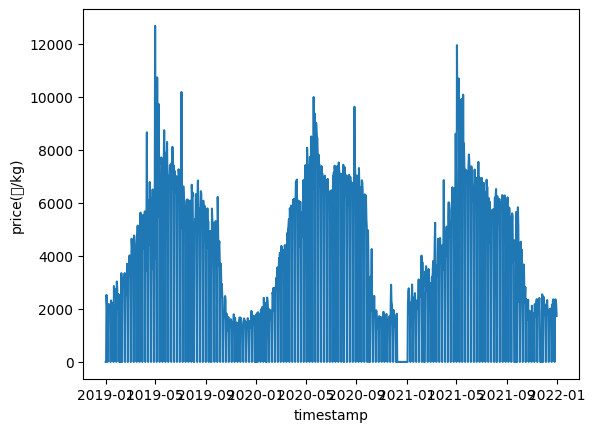

In [85]:
figure("감귤 가격")
lineplot(data=jeju_2019_A_S,x="timestamp",y="price(원/kg)")
show()
close()

시계열 분석 방법인 ARIMA 와 비교하는 것도 좋은 경험이겠지만 LLM과는 관련성이 낮아 하지않겠습니다

### 2. Dataset setting

window size(sequence length) : 30 day

batch_size=2

In [90]:
import tensorflow as tf
import tensorflow.keras as keras

In [ ]:
price_array=

In [95]:
dataset=keras.utils.timeseries_dataset_from_array(
    jeju_2019_A_S,
    targets=jeju_2019_A_S[30:],
    sequence_length=30,
    batch_size=2
)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type Timestamp).

In [93]:
help(keras.utils.timeseries_dataset_from_array)

Help on function timeseries_dataset_from_array in module keras.src.utils.timeseries_dataset_utils:

timeseries_dataset_from_array(data, targets, sequence_length, sequence_stride=1, sampling_rate=1, batch_size=128, shuffle=False, seed=None, start_index=None, end_index=None)
    Creates a dataset of sliding windows over a timeseries provided as array.

    This function takes in a sequence of data-points gathered at
    equal intervals, along with time series parameters such as
    length of the sequences/windows, spacing between two sequence/windows, etc.,
    to produce batches of timeseries inputs and targets.

    Args:
        data: Numpy array or eager tensor
            containing consecutive data points (timesteps).
            Axis 0 is expected to be the time dimension.
        targets: Targets corresponding to timesteps in `data`.
            `targets[i]` should be the target
            corresponding to the window that starts at index `i`
            (see example 2 below).
  